# **Traditional Image Feature Extractor with OpenCV**

This notebook implements a Traditional Image Feature Extractor using Python libraries such as `OpenCV`, `NumPy`, and `Matplotlib`. It covers various techniques including Sobel operation, Canny Edge Detection, SIFT (Scale-Invariant Feature Transform), and SURF (Speeded-Up Robust Features),. Below is a brief overview of each technique:

## **Setup and Installation**  

Install the required libraries: `matplotlib`, `numpy`, and `pillow`.

In [1]:
!pip install opencv-python numpy matplotlib

Download a sample image for demonstration purposes.

In [2]:
!wget -O sample.jpg https://cdn.pixabay.com/photo/2024/02/28/07/42/european-shorthair-8601492_640.jpg

--2024-10-16 02:17:26--  https://cdn.pixabay.com/photo/2024/02/28/07/42/european-shorthair-8601492_640.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43410 (42K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  42.39K  --.-KB/s    in 0.006s  

2024-10-16 02:17:26 (7.40 MB/s) - ‘sample.jpg’ saved [43410/43410]



## **Import Libraries**  

Import necessary modules and define utility functions for displaying images, converting between image and array formats, and loading images.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

## **Display and Convert Functions**  

Define helper functions to display multiple images, convert images to NumPy arrays, and vice versa.

In [4]:
# Display images function
def display_images(images: list, titles: list):
    n = len(images)
    if n > 1:
        cols = 3 if (n % 3) == 0 else 2  # Number of columns for the subplot
        rows = (n + cols - 1) // cols  # Calculate the number of rows needed
    else:
        cols = 1
        rows = 1
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5 * rows))

    if n == 1:
        axes.imshow(images[0][..., ::-1])
        axes.set_title(titles[0])
        axes.axis('off')
    else:
        axes = axes.flatten()  # Flatten the axes array for easy indexing

        for i in range(n):
            axes[i].imshow(images[i][..., ::-1])
            axes[i].set_title(titles[i])
            axes[i].axis('off')

        # Hide any unused subplots
        for j in range(n, rows * cols):
            axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Convert NumPy array back to OpenCV image
def array_to_image(array):
    array = np.clip(array * 255, 0, 255).astype(np.uint8)
    return array

## **Load and Display Image**  

Load the downloaded image and display it.

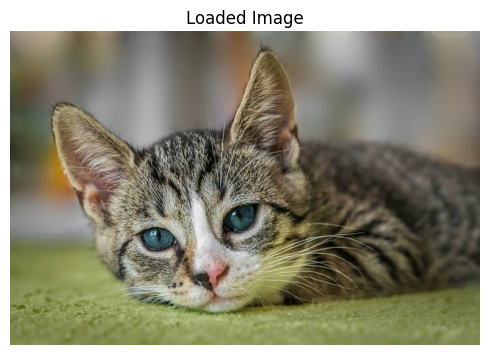

In [5]:
# Load the image
def load_image(image_path):
    return cv2.imread(image_path)

image_path = 'sample.jpg'
image = load_image(image_path)
display_images([image], ['Loaded Image'])

## **Edge Detection**

### **Sobel Operator**  

The Sobel operator is a widely used edge detection technique in image processing. It works by calculating the gradient of the image intensity at each pixel, which helps to identify regions of high spatial frequency that correspond to edges.

The Sobel operator uses two 3x3 convolution kernels, one for detecting changes in the horizontal direction ($Gx$) and another for the vertical direction ($Gy$). The kernels are defined as follows:

$$
G_x =
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

$$
G_y =
\begin{bmatrix}
 1 &  2 &  1 \\
 0 &  0 &  0 \\
-1 & -2 & -1
\end{bmatrix}
$$

To apply the Sobel operator, the image is convolved with both kernels. The gradient magnitude at each pixel can be calculated using the following formula:

$$
G = \sqrt{Gx^2 + Gy^2}
$$

Where $G$ is the gradient magnitude, $Gx$ is the gradient in the x-direction, and $Gy$ is the gradient in the y-direction. The result is an image that highlights the edges present in the original image.

The Sobel operator is particularly effective for detecting edges in images with noise, as it smooths the image while detecting edges.


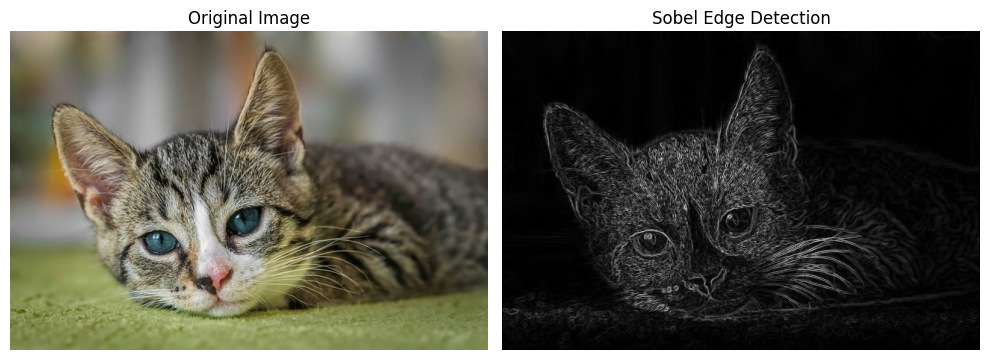

In [7]:
# Sobel Operation
def sobel_operation(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    grad = np.sqrt(sobel_x**2 + sobel_y**2)
    grad_norm = (grad * 255 / grad.max()).astype(np.uint8)
    grad_norm = cv2.cvtColor(grad_norm, cv2.COLOR_RGB2BGR)
    return grad_norm


sobel_image = sobel_operation(image)

display_images([image, sobel_image], ['Original Image', 'Sobel Edge Detection'])

### **Canny Edge Detection**  

Canny Edge Detection is a multi-stage algorithm used to detect a wide range of edges in images. It is known for its ability to detect edges with a high degree of accuracy and is widely used in computer vision applications.

The Canny edge detection algorithm consists of the following steps:

1. **Noise Reduction**: The first step involves applying a Gaussian filter to smooth the image and reduce noise. This is important because noise can lead to false edge detection. The Gaussian filter is defined by the following function: $$G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$$ where $\sigma$ is the standard deviation of the Gaussian distribution.

2. **Gradient Calculation**: The next step is to calculate the intensity gradient of the image. This is typically done using the Sobel operator, which computes the gradient in both the x and y directions. The gradients are given by: $$ G_x = \frac{\partial I}{\partial x}, \quad G_y = \frac{\partial I}{\partial y} $$ The gradient magnitude is then calculated as: $$G = \sqrt{G_x^2 + G_y^2}$$ and the gradient direction is computed as: $$ \theta = \arctan\left(\frac{G_y}{G_x}\right)$$

3. **Non-Maximum Suppression**: This step involves thinning the edges by suppressing non-maximum pixels in the gradient magnitude image. This is done to create a binary image where only the strongest edges remain.

4. **Double Thresholding**: In this step, two thresholds are applied to classify pixels as strong, weak, or non-edges. Strong edges are those above the high threshold, weak edges are those between the low and high thresholds, and non-edges are those below the low threshold.

5. **Edge Tracking by Hysteresis**: Finally, weak edges are retained only if they are connected to strong edges. This helps to eliminate false edges and ensures that only significant edges are detected.



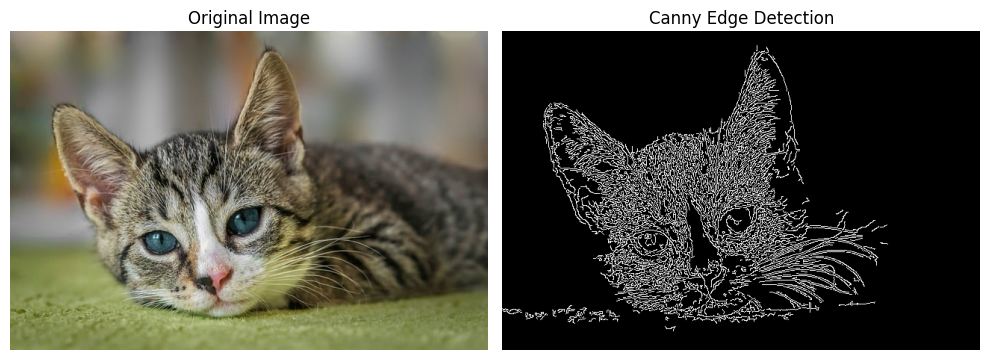

In [8]:
# Canny Edge Detection
def canny_edge_detection(image):
    edges = cv2.Canny(image, 100, 200)
    edges = cv2.cvtColor(edges, cv2.COLOR_RGB2BGR)
    return edges

canny_image = canny_edge_detection(image)


display_images([image, canny_image], ['Original Image', 'Canny Edge Detection'])

## **Keypoint Detection**

### **SIFT (Scale-Invariant Feature Transform)**  

SIFT (Scale-Invariant Feature Transform) is a feature detection algorithm that identifies and describes local features in images. It is particularly robust to changes in scale, rotation, and illumination, making it useful for various computer vision tasks such as object recognition and image stitching.

The SIFT algorithm consists of several key steps:

1. **Scale-space Extrema Detection**: SIFT identifies potential interest points by searching for local extrema in a difference-of-Gaussian (DoG) function across different scales. The DoG is computed as: $$ D(x, y, \sigma) = G(x, y, k\sigma) - G(x, y, \sigma) $$where $ G(x, y, \sigma) $ is a Gaussian function and $ k $ is a constant factor.

2. **Keypoint Localization**: The algorithm refines the keypoints by eliminating low-contrast points and edge responses, ensuring that only stable keypoints are retained.

3. **Orientation Assignment**: Each keypoint is assigned one or more orientations based on local image gradients, which helps achieve rotation invariance. The orientation is calculated as: $$ \theta = \arctan\left(\frac{G_y}{G_x}\right) $$ where $ G_x $ and $ G_y $ are the gradients in the x and y directions, respectively.

4. **Keypoint Descriptor**: A descriptor is created for each keypoint by computing the gradient magnitudes and orientations in a local neighborhood around the keypoint. This results in a 128-dimensional vector that describes the keypoint's appearance.


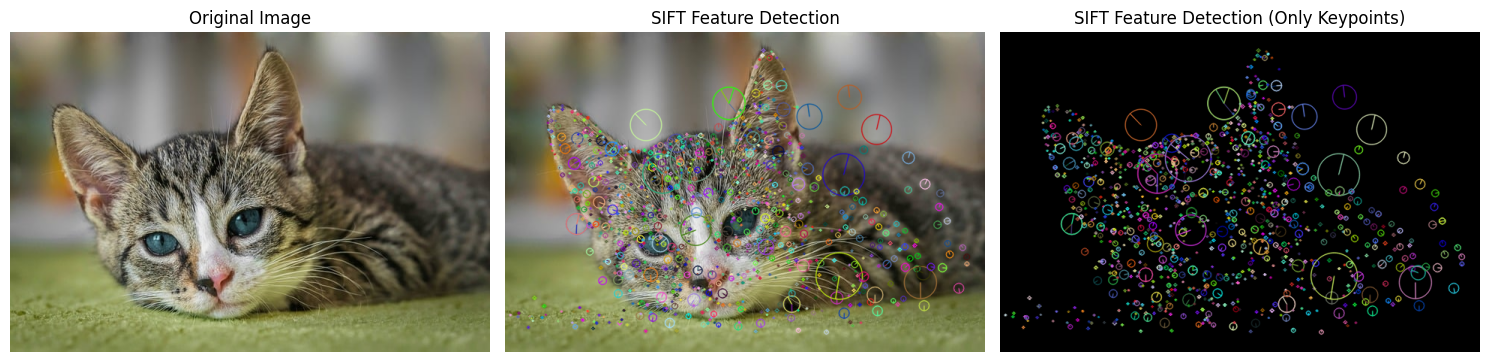

In [9]:
# SIFT (Scale-Invariant Feature Transform)
def sift_feature_detection(image):
    sift = cv2.SIFT_create()  # Create a SIFT detector
    keypoints, descriptors = sift.detectAndCompute(image, None)
    sift_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    blank_image = np.zeros_like(image)
    sift_only = cv2.drawKeypoints(blank_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return sift_image, sift_only

# Example usage of SIFT
sift_image, sift_only = sift_feature_detection(image)

# Display original and SIFT images
display_images([image, sift_image, sift_only], ['Original Image', 'SIFT Feature Detection', 'SIFT Feature Detection (Only Keypoints)'])